In [1]:
%env CUDA_VISIBLE_DEVICES=3
%env LIBRARY_PATH=/usr/local/cuda/lib64

env: CUDA_VISIBLE_DEVICES=3
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [2]:
import sys

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

%matplotlib inline

In [4]:
import numpy as np

## Simple model


$$x \sim \mathcal{N}(x|\mu, 1)$$

$$y \sim \mathcal{N}(y|x, 1)$$

#### Problem statement

Recover $p(y|\mu)$ with differentable neural network and be able to make gradient step of some statistic from 

$$r = R\left( \{ y_i \}_{i=0}^{B} \right)$$, 

i.e. be able to calculate:

$$\frac{\partial r}{\partial \mu} = ?$$.

## Make model with `pyro`

In [5]:
mu = torch.tensor(12., requires_grad=True)
mu = pyro.param('mu', mu)

In [6]:
x_dist = dist.Normal(mu, 1)

In [7]:
def f(x):
    return x.sin() + x.tanh()

#@pyro.condition(data={"x": torch.tensor(1.)})
def y_sample():
    x = pyro.sample("x", x_dist)
    x = f(x)
    return pyro.sample("y", dist.Normal(x, 1))

In [8]:
conditioned_y_sample = poutine.condition(y_sample, data={"x": torch.tensor(-1.)})

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [9]:
def r(ys: torch.tensor, Y_0=-5):
    return (ys - Y_0).pow(2).mean()

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

## Investigation of the model

In [10]:
samples = torch.stack([y_sample() for _ in range(10000)])

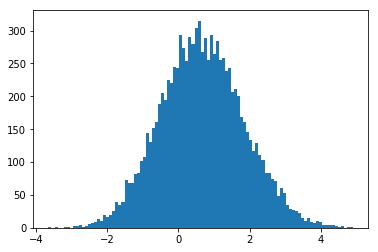

In [11]:
plt.hist(samples.detach().cpu().numpy(), bins=100);

In [25]:
r(samples).item()

33.678306579589844

In [120]:
samples = torch.stack([conditioned_y_sample() for _ in range(10000)])

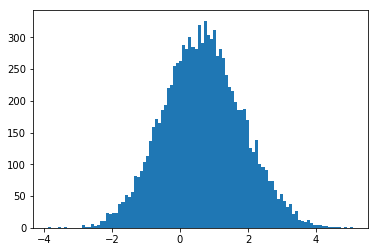

In [121]:
plt.hist(samples.detach().cpu().numpy(), bins=100);

# GANS

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [13]:
device = torch.device("cuda", 0)

In [14]:
import numpy as np


NOISE_DIM = 4
def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

In [28]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=1):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z, params):
        """
            Generator takes a vector of noise and produces sample
        """
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

In [29]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100, input_param=1):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x, params):
        #x = torch.cat([x, params.repeat(x.shape[0], 1)], dim=1)
        x = torch.cat([x, params], dim=1)
        h1 = torch.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        score = torch.sigmoid(self.fc4(h3))
        return score

In [30]:
generator = Generator(NOISE_DIM, out_dim = 1).to(device)
discriminator = Discriminator(in_dim = 1).to(device)

lr = 0.001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [18]:
################################
# IMPLEMENT HERE
# Define the g_loss and d_loss here
# these are the only lines of code you need to change to implement GAN game

#d_loss(discriminator(data_gen), discriminator(inp_data))
#g_loss(discriminator(data_gen))
def g_loss(discrim_output):
    eps = 1e-10
    if TASK == 1: 
        loss = torch.log(1 - discrim_output + eps).mean()    
    elif TASK == 2:
        loss = - torch.log(discrim_output + eps).mean()
    elif TASK in (3, 4):
        loss = - discrim_output.mean()
    return loss


def d_loss(discrim_output_gen, discrim_output_real):
    eps = 1e-10
    if TASK in (1, 2): 
        loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
    elif TASK in (3, 4):
        loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
    return loss
################################

In [35]:
num_epochs = 100
batch_size = 32 # initially was 64
TASK = 2

In [36]:
from tqdm import trange

In [31]:
#data = torch.stack([y_sample() for _ in range(100000)]).reshape(-1,1)
#data = torch.Tensor([y_sample().item() for _ in range(100000)]).reshape(-1,1)
fixed_noise = torch.Tensor(sample_noise(10000)).to(device)
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in trange(0, X.shape[0], batchsize):
        end = min(start + batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

In [55]:
def generate_data(n_mu,n_samples_per_mu, mu_range=(-5,5)):
    data = []
    mus = []
    for mu_number in range(n_mu):
        mu.data = torch.tensor(np.random.uniform(*mu_range))
        mus.extend([mu.item()] * n_samples_per_mu)
        data.extend([y_sample().item() for _ in range(n_samples_per_mu)])
    return torch.Tensor(data).reshape(-1,1), torch.Tensor(mus).reshape(-1,1).to(device)

data, mus = generate_data(100, 100)

In [56]:
from IPython import display
def run_training():
    #plt.xlim(lims)
    #plt.ylim(lims)

    # ===========================
    # IMPORTANT PARAMETER:
    # Number of D updates per G update
    # ===========================
    k_d, k_g = 4, 1

    dis_loss, gen_loss = [], []

    try:
        for epoch in range(num_epochs):
            dis_epoch_loss = []
            gen_epoch_loss = []
                        
            for input_data, input_mu in iterate_minibatches(data, batch_size, y=mus):
                # Optimize D
                for _ in range(k_d):
                    # Sample noise
                    noise = torch.Tensor(sample_noise(len(input_data))).to(device)

                    # Do an update
                    inp_data = torch.Tensor(input_data).to(device)
                    data_gen = generator(noise, input_mu)

                    loss = d_loss(discriminator(data_gen, input_mu), discriminator(inp_data, input_mu))
                    if TASK == 4:
                        grad_penalty = calc_gradient_penalty(data_gen.data, inp_data.data)
                        loss += grad_penalty
                        
                    d_optimizer.zero_grad()
                    loss.backward()
                    d_optimizer.step()

                    if TASK == 3:                    
                        for p in discriminator.parameters():
                            p.data.clamp_(clamp_lower, clamp_upper)
                dis_epoch_loss.append(loss.item())

                # Optimize G
                for _ in range(k_g):
                    # Sample noise
                    noise = torch.Tensor(sample_noise(len(input_data))).to(device)

                    # Do an update
                    data_gen = generator(noise, input_mu)
                    loss = g_loss(discriminator(data_gen, input_mu))
                    g_optimizer.zero_grad()
                    loss.backward()
                    g_optimizer.step()
                gen_epoch_loss.append(loss.item())
            dis_loss.append(np.mean(dis_epoch_loss))
            gen_loss.append(np.mean(gen_epoch_loss))
            # Visualize
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
            ax1.set_title("Epoch {}".format(epoch))
            ax1.hist(data.detach().cpu().numpy(), bins=100, normed=True, label='true');
            ax1.hist(generator(fixed_noise, mus).detach().cpu().numpy(),
                     bins=100, color='g', normed=True, alpha=0.5, label='gan');
            ax1.grid()
            ax1.legend()
            
            ax2.plot(dis_loss, label='d_loss', c='b')
            ax2.set_title("epoch")
            ax2.set_title("loss")
            ax2.grid()
            ax2.legend()
            
            ax3 = ax2.twinx()
            ax3.plot(gen_loss, label='g_loss', c='r')
            ax3.grid()
            ax3.legend()
            
            
            display.clear_output(wait=True)
            plt.show()


    except KeyboardInterrupt:
        pass

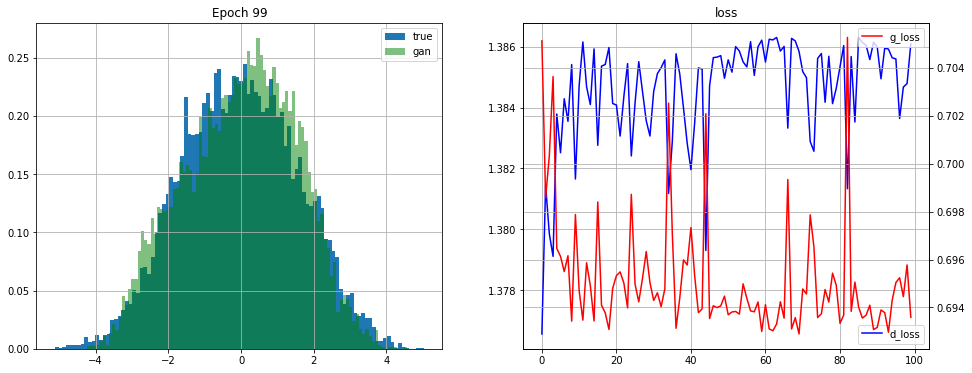

In [57]:
run_training()

# Conditional GAN simple results

In [64]:
mu.data = torch.tensor(np.random.uniform(-5, 5))
data = torch.Tensor([y_sample().item() for _ in range(10000)]).reshape(-1,1)
input_mu = torch.Tensor([mu.item()] * fixed_noise.shape[0]).reshape(-1,1).to(device)

In [65]:
print(input_mu[0], f(input_mu[0]))

tensor([-2.9352], device='cuda:0') tensor([-1.1993], device='cuda:0')


/mnt/shirobokov/conda/envs/pytorch/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


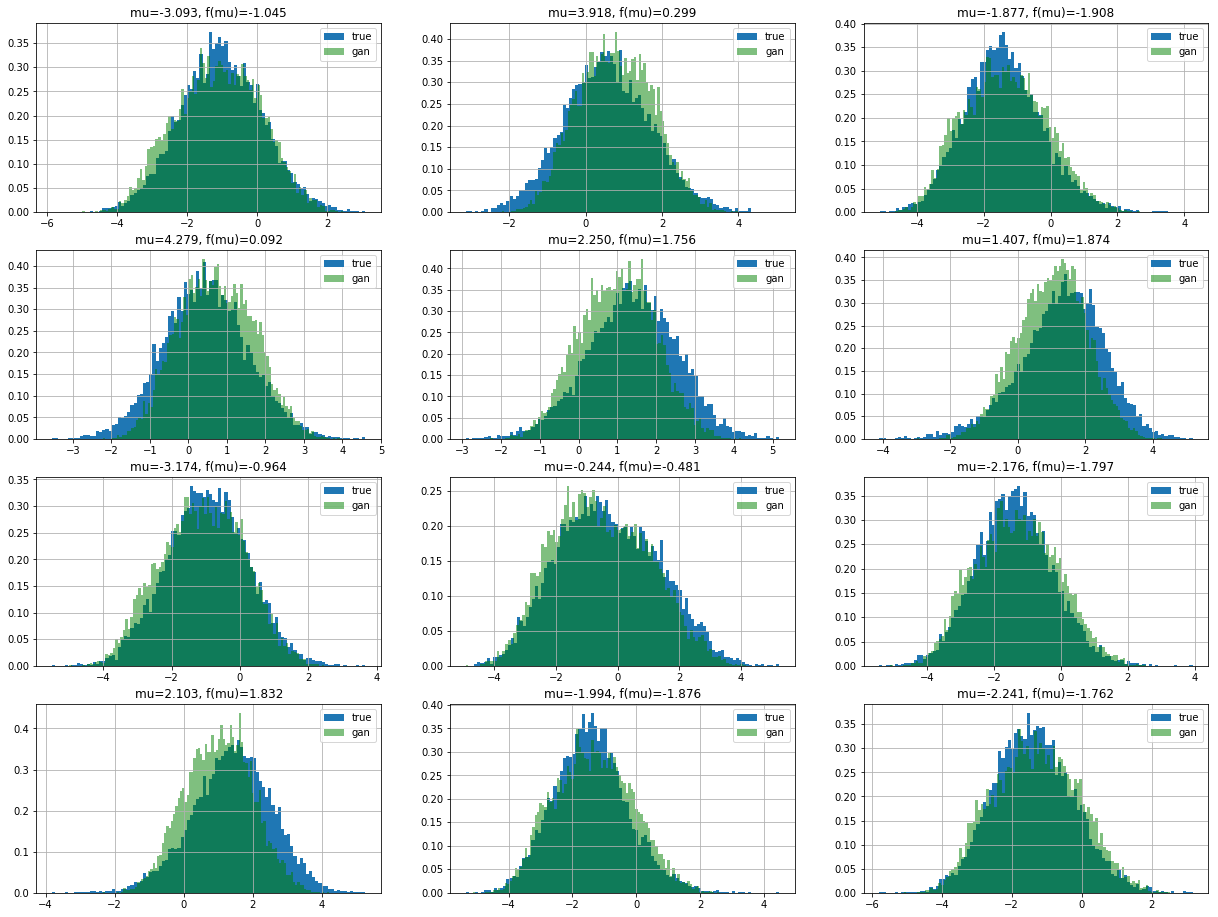

In [179]:
plt.figure(figsize=(21,16))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        mu.data = torch.tensor(np.random.uniform(-5, 5))
        data = torch.Tensor([y_sample().item() for _ in range(10000)]).reshape(-1,1)
        input_mu = torch.Tensor([mu.item()] * fixed_noise.shape[0]).reshape(-1,1).to(device)            

        plt.hist(data.detach().cpu().numpy(), bins=100, normed=True, label='true');
        plt.hist(generator(fixed_noise, input_mu).detach().cpu().numpy(),
                 bins=100, color='g', normed=True, alpha=0.5, label='gan');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}, f(mu)={:.3f}".format(input_mu[0].item(), f(input_mu[0]).item()))

In [184]:
#torch.save(generator, "gen_fitted.pt")

gen_fitted.pt  model.ipynb  README.md


# Test on mu outside of training domain 

Text(0.5, 1.0, 'mu=50.000, f(mu)=0.738')

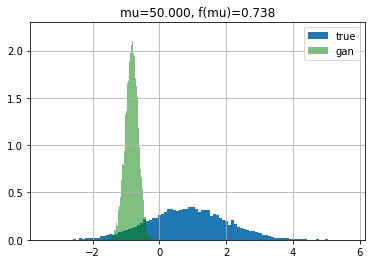

In [85]:
#mu.data = torch.tensor(np.random.uniform(-5, 5))
mu.data = torch.tensor(15.)
data = torch.Tensor([y_sample().item() for _ in range(10000)]).reshape(-1,1)
input_mu = torch.Tensor([mu.item()] * fixed_noise.shape[0]).reshape(-1,1).to(device)            

plt.hist(data.detach().cpu().numpy(), bins=100, normed=True, label='true');
plt.hist(generator(fixed_noise, input_mu).detach().cpu().numpy(),
     bins=100, color='g', normed=True, alpha=0.5, label='gan');
plt.grid()
plt.legend()
plt.title("mu={:.3f}, f(mu)={:.3f}".format(input_mu[0].item(), f(input_mu[0]).item()))

In [88]:
for mu_val in np.arange(-4,4, 0.5):
    mu.data = torch.tensor(mu_val)
    data = torch.Tensor([y_sample().item() for _ in range(10000)]).reshape(-1,1)
    print(mu.item(), r(data))

-4.0 tensor(21.2289)
-3.5 tensor(19.1463)
-3.0 tensor(17.0179)
-2.5 tensor(14.9768)
-2.0 tensor(14.3301)
-1.5 tensor(14.8248)
-1.0 tensor(17.4112)
-0.5 tensor(22.1665)
0.0 tensor(27.5096)
0.5 tensor(33.4067)
1.0 tensor(38.7621)
1.5 tensor(41.8998)
2.0 tensor(42.5494)
2.5 tensor(40.8693)
3.0 tensor(38.3111)
3.5 tensor(34.6503)


In [331]:
from copy import deepcopy

In [354]:
class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
        
    def forward(self, noise, mu):
        
        return self.gen(noise, mu)

In [375]:
io_model = InputOptimisation(generator)

lr = 0.1
# io_optimizer = optim.Adam(io_model.parameters(), lr=lr)

sample_size = 1000

In [376]:
mu_optim = torch.tensor(0.)

mu_optim = mu_optim.reshape(-1,1).repeat(sample_size,1).to(device)
mu_optim.requires_grad=True

In [377]:
%%time
n_iter = 10000
losses = []
m_vals = []
for _iter in range(n_iter):    
    noise = torch.Tensor(sample_noise(sample_size)).to(device)
    #print(mu_optim[:2, 0])
    # Do an update
    data_gen = io_model(noise, mu_optim)
    loss = r(data_gen)
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0,0].item())

CPU times: user 13.2 s, sys: 504 ms, total: 13.7 s
Wall time: 14.9 s


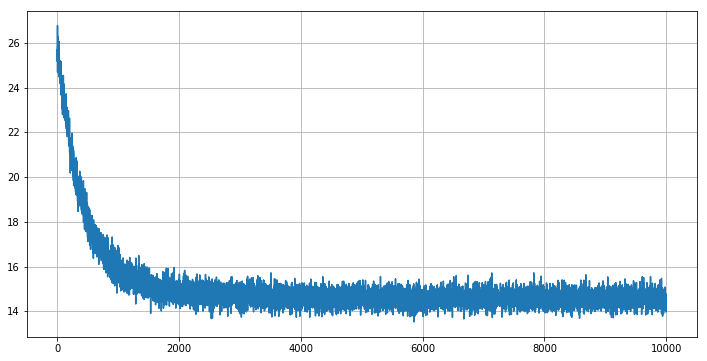

In [378]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()

In [359]:
np.min(losses)

13.492064476013184